<a href="https://colab.research.google.com/github/royam0820/fastai2-v4/blob/master/05_Multi_Label_Planet_big.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-label prediction with the Planet Amazon dataset
[Amazon Kaggle Dataset](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space)

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Intalling the new fastai version 2
Google Colab has in store an older version of fastai.  So we need to upgrade it.

In [ ]:
!pip install pandas==1.1.0

NOTE: to prevent this error when upgrading fastai

ERROR: google-colab 1.0.0 has requirement pandas~=1.0.0; python_version >= "3.0", but you'll have pandas 1.1.1 which is incompatible.

In [ ]:
#Run once per session
!pip install fastai --upgrade -q

     |████████████████████████████████| 358kB 5.0MB/s 


In [ ]:
import fastai; fastai.__version__

'1.0.61'

In [ ]:
!pip install nbdev -q
!pip install utils -q


In [ ]:
from fastai.vision.all import *
from fastai.imports import *
from utils import *
from nbdev.showdoc import *

# Getting the data from Kaggle

The planet dataset isn't available on the [fastai dataset page](https://course.fast.ai/datasets) due to copyright restrictions. You can download it from Kaggle however. Let's see how to do this by using the [Kaggle API](https://github.com/Kaggle/kaggle-api) as it's going to be pretty useful to you if you want to join a competition or use other Kaggle datasets later on.

First, install the Kaggle API by uncommenting the following line and executing it, or by executing it in your terminal (depending on your platform you may need to modify this slightly to either add `source activate fastai` or similar, or prefix `pip` with a path. Have a look at how `conda install` is called for your platform in the appropriate *Returning to work* section of https://course.fast.ai/. (Depending on your environment, you may also need to append "--user" to the command.)

In [ ]:
! pip install kaggle --upgrade

Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands (or run them in a terminal).

In [ ]:
! mkdir -p ~/.kaggle/
! mv '/content/kaggle.json' ~/.kaggle

NOTE: make sure to upload the `kaggle.json` file to the default colab content directory. Once this instruction is run, you will find the file in /root/.kaggle

In [ ]:
# making the Kaggle API readable by only you.
!chmod 600 /root/.kaggle/kaggle.json 
!ls -l

total 4
drwxr-xr-x 1 root root 4096 Aug 27 16:39 sample_data


In [ ]:
# checking the Kaggle API version
!kaggle -v

Kaggle API 1.5.8


You're all set to download the data from [planet competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space). You **first need to go to its main page and accept its rules**, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a `403 forbidden` error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on *Rules* tab, and then scroll to the bottom to find the *accept* button).

In [ ]:
# identifying the path for the Kaggle download
path=Path('.'); path

Path('.')

## Kaggle dataset data files
[data files](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data)

In [ ]:
# testing the Kaggle connection
! kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes        235           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes         67           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        360           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2648           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      19347           False  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       5070           False  
connectx

In [ ]:
# accessing the Kaggle learderboard
! kaggle competitions leaderboard planet-understanding-the-amazon-from-space -s

In [ ]:
# accessing a competition dataset
!kaggle competitions files -c planet-understanding-the-amazon-from-space

name                                                size  creationDate         
-------------------------------------------------  -----  -------------------  
sample_submission_v2.csv/sample_submission_v2.csv    3MB  2019-12-15 22:14:13  
train_v2.csv/train_v2.csv                            1MB  2019-12-15 22:14:13  
test_v2_file_mapping.csv/test_v2_file_mapping.csv  600KB  2019-12-15 22:14:13  
Kaggle-planet-train-tif.torrent                      1MB  2019-12-15 22:14:13  
Kaggle-planet-test-tif.torrent                       2MB  2019-12-15 22:14:13  


NOTE: The image files: train and test datasets have been converted into a bittorrent download.  However, a user was able to constitute a more accessible datasets. See instructions below to gain access to the datasets.

NB: the `train_v2.csv` has been renamed `train_classes.csv`

In [ ]:
# ORIGINAL FILES EXTRACTION
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv/train_v2.csv  -p {path}  
# ! unzip -q -n {path}/train_v2.csv.zip -d {path}

In [ ]:
# NEW - files extraction from user nkitarom
!kaggle datasets download nikitarom/planets-dataset -p "{path}"
!unzip -q -n '{path}'/planets-dataset.zip -d '{path}'

 99% 1.48G/1.50G [00:20<00:00, 79.0MB/s]
100% 1.50G/1.50G [00:20<00:00, 76.9MB/s]


In [ ]:
path.ls()

(#5) [Path('.config'),Path('planet'),Path('planets-dataset.zip'),Path('test-jpg-additional'),Path('sample_data')]

# Multiclassification

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [ ]:
# changing the path to gain access to the planet dataset path
path = Path('/content/planet/planet'); path


Path('/content/planet/planet')

In [ ]:
df = pd.read_csv(path/'train_classes.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


The `train_classes.csv` file has two columns:
- the `image_name`; images to be trained are stored in direction `train-jpg`.
- the `tags` refers to our labels for a given image; we can have multiple labels, each label is separated by a blank space.

# The dataloader
This is the fastai datablock API.

In deep learning projects a crucial step before starting to train any model is to have a dataloader capable of feeding the model with batches of data and performing operations such as image augmentations.

Dataloaders is a fastai class that will provide the data to your model and divide the dataset into a training set and a validation set.

In [ ]:
# batch_tfms = aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0., size=128)

In [ ]:
# batch transformation - image size = 128 px
batch_tfms = aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0., size=128, batch=True)

In [ ]:
??aug_transforms

In [ ]:
path

Path('/content/planet/planet')

In [ ]:
# the MultiCategory datablock
planet = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader(0, pref=f'{path}/train-jpg/', suff='.jpg'),
                   splitter=RandomSplitter(),
                   get_y=ColReader(1, label_delim=' '),
                   batch_tfms = batch_tfms)

* Multi-labels so we want a `MultiCategoryBlock`. Multi-labels is a list of labels.
* `get_x` and `get_y` define how we expect to grab our data
* `RandomSplitter`: Create a function that splits `items` between train/val with `valid_pct` randomly.
* `ColReader` works with Pandas `DataFrames`; in our dataframe, the column `tags` will be used to get the labels; the labels are separated by a blank space.


In [ ]:
??DataBlock

In [ ]:
??RandomSplitter()

In [ ]:
??batch_tfms

Now we can create dataloaders by passing in our source folder

In [ ]:
# passing to the dataloader the pandas dataframe to get the image and labels.
#dls = planet.dataloaders(df)
dls = planet.dataloaders(df)

In [ ]:
# # showing resizing applied
dls.train_ds[0][0].shape

In [ ]:
print(len(dls.train_ds), len(dls.valid_ds))

32384 8095


### One-hot Encoding
Using a vector of 0s, with  a 1 in each location that is represented in the data, to encode a list of integers.

In [ ]:
# number of categories
print(dls.c)

17


In [ ]:
dls.dataset

In [ ]:
# one-hot encoding - MultiCategory
# list of categories for one example
dls.dataset[0]

(PILImage mode=RGB size=256x256,
 TensorMultiCategory([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]))

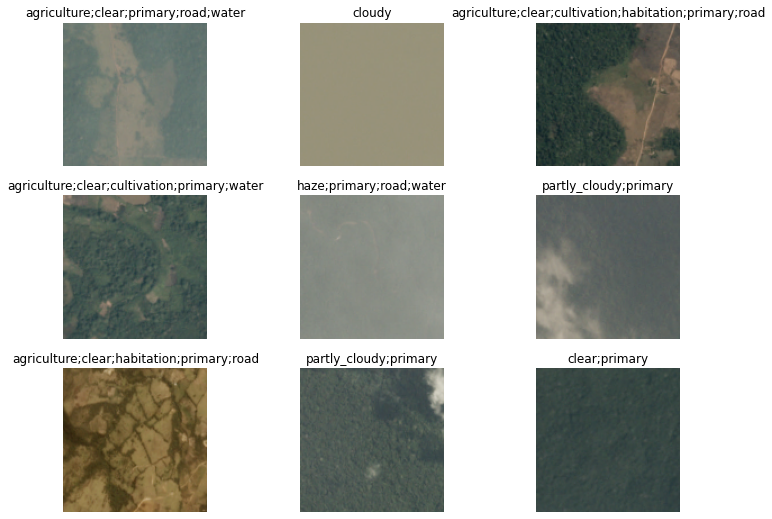

In [ ]:
# show the dataloader batch content
dls.show_batch(max_n=9, figsize=(12,9))

# Training the model

To create a `Learner` we use the same function as in lesson 1. Our base architecture is resnet34 again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [ ]:
from torchvision.models import resnet34

In [ ]:
from fastai.metrics import accuracy_multi

In [ ]:
learn = cnn_learner(dls, resnet34, pretrained=True, metrics=[accuracy_multi])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
# acc_02 = partial(accuracy_thresh, thresh=0.2)
# f_score = partial(fbeta, thresh=0.2)
# learn = create_cnn(data, arch, metrics=[acc_02, f_score])

In [ ]:
??accuracy_multi

In [ ]:
class BCEWithLogitsLossFlat(BaseLoss):
    "Same as `nn.CrossEntropyLoss`, but flattens input and target."
    def __init__(self, *args, axis=-1, floatify=True, thresh=0.5, **kwargs):
        super().__init__(nn.BCEWithLogitsLoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
        self.thresh = thresh

    def decodes(self, x):    return x>self.thresh
    def activation(self, x): return torch.sigmoid(x)

In [ ]:
learn.loss_func = BCEWithLogitsLossFlat()

NOTE: fastai has many loss functions and, of course you can add your own as well, here is the [link](https://docs.fast.ai/layers.html#fastai-loss-functions) to the loss functions readily available with fastai.  The above code was directly taken from the fastai library.

We use the LR Finder to pick a good learning rate.

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.02754228748381138)

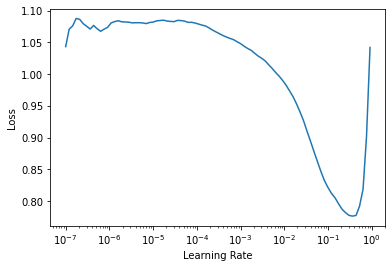

In [ ]:
learn.lr_find()

And train! (we'll also used mixed precision too!)

In [ ]:
# learning rate
lr = 1e-2
# using mixed precision
from fastai.callback.fp16 import * # a callback call for mixed precision
learn = learn.to_fp16()

NOTE: mixed precision is a technique referring to using less precise numbers (half precision floating point, also called `fp16` during training. NVIDIA GPU, since early 2020, supports a special feature called `tensor cores` that can dramatically speed up neural network training by 2-3x.  They also require a lot less GPU memory.  To enable this feature, just add `to_fp16()` after your learner creation.

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.142533,0.124925,0.952374,01:57
1,0.114263,0.103349,0.959881,01:56
2,0.106358,0.095458,0.963100,01:56
3,0.101584,0.092068,0.964139,01:56
4,0.097622,0.090395,0.964866,01:56


In [ ]:
learn.save('stage-1-rn34')

Path('models/stage-1-rn34.pth')

...And fine-tune the whole model:

In [ ]:
learn.unfreeze()

SuggestedLRs(lr_min=3.311311274956097e-07, lr_steep=2.2908675418875646e-06)

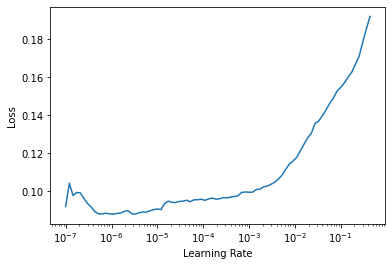

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.099659,0.095006,0.963231,02:02
1,0.096891,0.091537,0.964808,02:02
2,0.091020,0.087587,0.965963,02:02
3,0.085462,0.085410,0.966617,02:02
4,0.077213,0.084841,0.967177,02:02


In [ ]:
learn.save('stage-2-rn34')

Path('models/stage-2-rn34.pth')

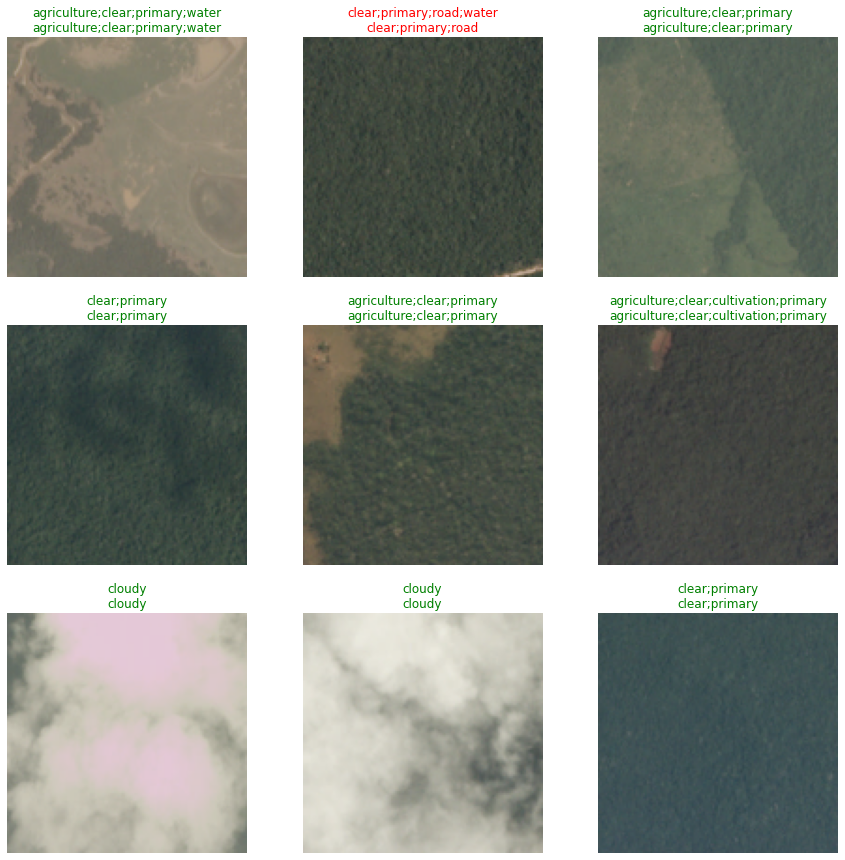

In [ ]:
learn.show_results(figsize=(15,15))

NOTE: The results shows the prediction v.s. the actual value.
Red means the model did bad. 

In [ ]:
??show_results()

# Progressive Resizing
The previous run was done with a default image size of 256 px. Now we will run a progressive resizing, the advantage is that we are actually doing a transfer learning as well as a data augmentation by the gradual resizing.

## Image size 128, batch size 128

In [ ]:
path

In [ ]:
learn.load('/content/models/stage-1')

In [ ]:
batch_tfms = aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0., size=256)

In [ ]:
def get_dls(size, bs):
  planet = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(size),
                   batch_tfms = batch_tfms)
  return planet.dataloaders(path, bs=bs)

In [ ]:
# resizing with pictures at 128 px and a batch size at 128
dls = get_dls(128, 128)

In [ ]:
dls.after_item

In [ ]:
# # showing resizing applied
# dls.train_ds[0][0].shape

In [ ]:
# displaying the current batch size
dls.bs

In [ ]:
# Learner - using a resnet50
learn = cnn_learner(dls, resnet50, pretrained=True, metrics=[accuracy_multi])

In [ ]:
learn.lr_find()

In [ ]:
lr=1e-2/2

In [ ]:
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.081056,0.088567,0.965542,02:47
1,0.081986,0.087849,0.966036,02:46
2,0.081520,0.087286,0.965956,02:46
3,0.076891,0.087192,0.966363,02:46
4,0.075721,0.086987,0.966326,02:46


In [ ]:
learn.save('stage-1-128-rn50')

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.082063,0.089280,0.966305,03:08
1,0.082961,0.089137,0.965556,03:07
2,0.079974,0.088379,0.965774,03:08


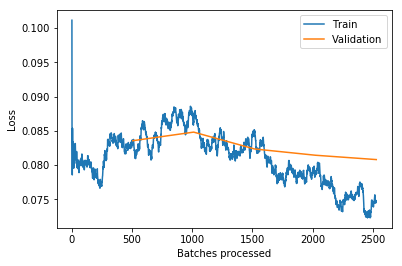

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2-128-rn50')

## Image size 224, batch size 64

In [ ]:
# resizing with pictures at 128 px and a batch size at 128
dls = get_dls(224, 64)

In [ ]:
dls.after_item

In [ ]:
dls.bs

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

In [ ]:
learn.show_results(figsize=(15,15))

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

In [ ]:
learn.export()